In [1]:
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.generators import random_walks
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')

sns.set_palette("pastel")
sns.set_style('whitegrid')

date = pd.date_range('2019-01-01','2021-08-23', freq = 'd')

x_data = random_walks(n_ts = 12, sz = 365, d = 1, random_state = 1234)
x_data2 = random_walks(n_ts = 12, sz = len(date)-365, d = 1, random_state = 1234)

C:\Users\icear\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [2]:
print('x_data shape :',x_data.shape)
print('x_data2 shape :',x_data2.shape)

x_data shape : (12, 365, 1)
x_data2 shape : (12, 601, 1)


- [tslearn.generators.random_walks docs](https://tslearn.readthedocs.io/en/stable/gen_modules/generators/tslearn.generators.random_walks.html)에 따르면 
  <br> n_ts : Number of time series.</br> 
  <br> sz : Length of time series (number of time instants).</br> 
  <br> d : Dimensionality of time series.</br><br></br>
<br></br>
- x_data의 경우 12개의 time series데이터, 365의 길이를 가지고 1개의 차원을 가진 데이터이다. 즉, 12x365x1의 데이터이다.
- x_data2의 경우 12개의 time series데이터, 601의 길이를 가지고 1개의 차원을 가진 데이터이다. 즉, 12x601x1의 데이터이다.

In [3]:
data = np.concatenate((x_data, x_data2), axis = 1)
data.shape

(12, 966, 1)

- 데이터를 하나로 합치고 12x966x1 차원의 데이터로 만들었다.

In [4]:
df = pd.DataFrame(data.reshape(-1,966)).T
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       966 non-null    float64
 1   1       966 non-null    float64
 2   2       966 non-null    float64
 3   3       966 non-null    float64
 4   4       966 non-null    float64
 5   5       966 non-null    float64
 6   6       966 non-null    float64
 7   7       966 non-null    float64
 8   8       966 non-null    float64
 9   9       966 non-null    float64
 10  10      966 non-null    float64
 11  11      966 non-null    float64
dtypes: float64(12)
memory usage: 90.7 KB


- 12개의 time series 데이터가 어떻게 생겼는지 파악 하기 위해 시각화를 해봐야겠다.
- 3차원 -> 2차원으로 변환시키고 dataframe으로 만들었다.

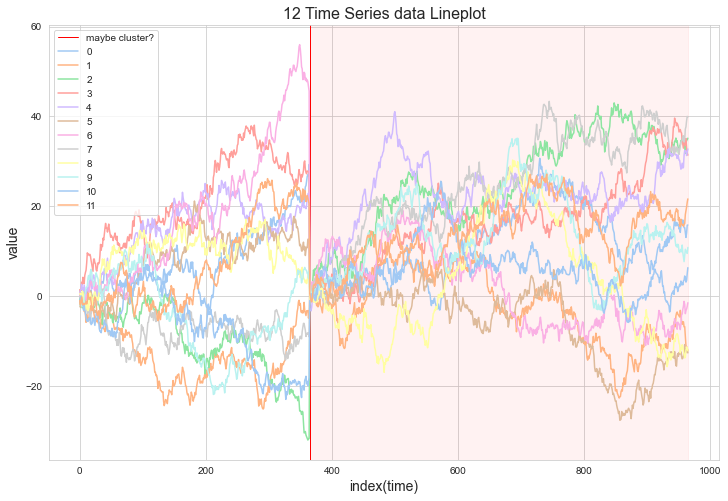

In [5]:
f, ax = plt.subplots(figsize = (12,8))
plt.axvline(365, color = 'red',label = 'maybe cluster?', linewidth = 1)
plt.axvspan(365, 966, color = 'red', alpha = 0.05)  

for i in range(12):
    df[i].plot()

plt.xlabel('index(time)', fontsize = 14)
plt.ylabel('value', fontsize = 14)
plt.legend()
plt.title('12 Time Series data Lineplot', fontsize = 16)
plt.show()

- 12개의 time series 데이터를 시각화해보았다.
- x_data와 x_data2를 365개 기준으로 전후로 나눴기 때문에 같은 label도 index 365번 이후로 차이가 많이 나는것이 확인 되었다.
<br></br><br></br>
- time series clustering을 하는것이 목표이므로 그냥 눈으로 봤을때는 어떻게 clustering을 진행해야하는지 한번에 보이지 않는다.
- tslearn의 TimeSeriesKMeans를 사용하기로 결정

In [6]:
k_means = TimeSeriesKMeans(n_clusters = 4, metric= 'dtw', max_iter = 5, random_state = 1234)
t_data = k_means.fit_predict(data)

- 손이 가는대로 4개의 클러스터로 나누고 metric은 'dtw'로 해보자
- 추후에 클러스터갯수는 최적으로 조정할 예정

In [7]:
k_means.cluster_centers_.shape

(4, 966, 1)

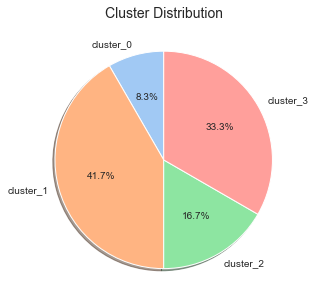

In [8]:
labels = []
sizes = []

for i in range(4):
    labels.append('cluster_'+str(i))
    sizes.append(collections.Counter(t_data)[i])

f, ax = plt.subplots(figsize = (10,5))
plt.pie(sizes,
        labels = labels,
        shadow = True,
        startangle = 90,
        autopct = '%1.1f%%')

plt.title('Cluster Distribution', fontsize = 14)
plt.show()

- random walk로 생성한 12개의 time series 데이터를 4개의 cluster로 나눈 결과 12개의 데이터중 약 41.7% 정도가 cluster_1에 할당되었다.

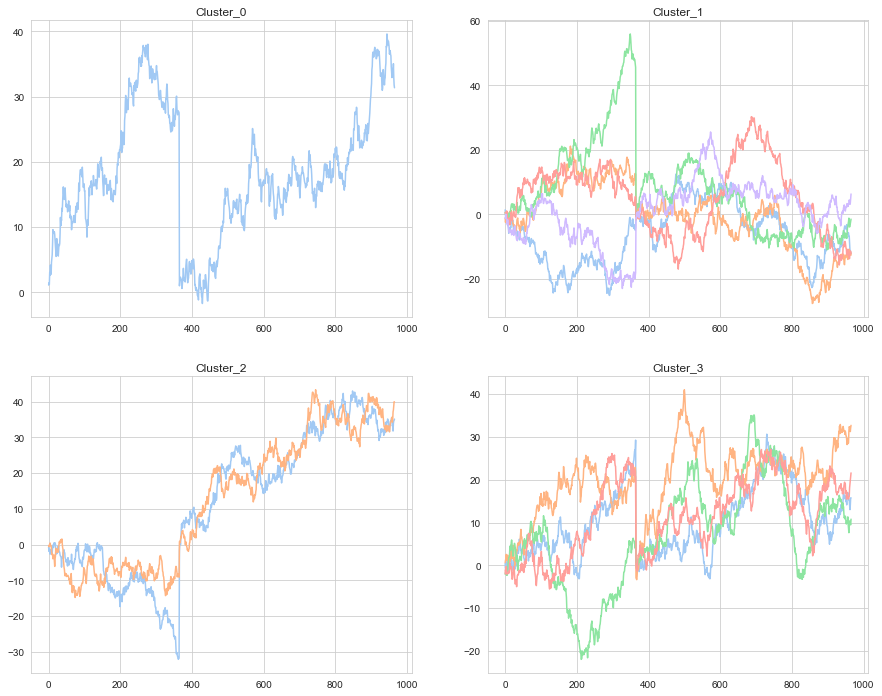

In [9]:
f, ax = plt.subplots(2,2, figsize = (15,12))

pd.DataFrame(data[[t_data==0]].reshape(-1,966)).T.plot(ax = ax[0,0], legend = None).set_title('Cluster_0', fontsize = 12)
pd.DataFrame(data[[t_data==1]].reshape(-1,966)).T.plot(ax = ax[0,1], legend = None).set_title('Cluster_1', fontsize = 12)
pd.DataFrame(data[[t_data==2]].reshape(-1,966)).T.plot(ax = ax[1,0], legend = None).set_title('Cluster_2', fontsize = 12)
pd.DataFrame(data[[t_data==3]].reshape(-1,966)).T.plot(ax = ax[1,1], legend = None).set_title('Cluster_3', fontsize = 12)

plt.show()

- 4개 clustering을 한 결과 위의 그래프처럼 나눠졌다.
- 다른쪽은 모르겠는데 cluster_2는 clutering이 잘된거같다.
<br></br><br></br>
- 최적의 k값을 찾아본다음에 다시 clutering을 진행해봐야겠다.

In [10]:
dist = []
for k in range(1,10):
    k_means = TimeSeriesKMeans(n_clusters = k, metric= 'dtw', max_iter = 5, random_state = 1234)
    k_means.fit(data)
    dist.append(k_means.inertia_)

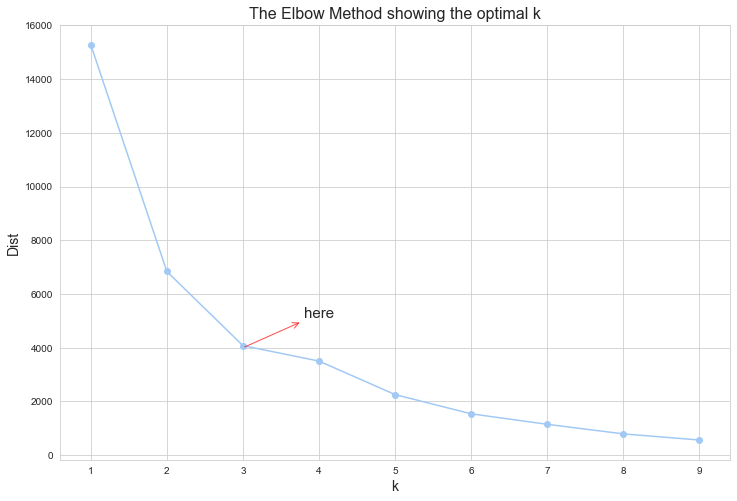

In [11]:
f, ax = plt.subplots(figsize = (12,8))
plt.plot(range(1,10), dist, '-o')
plt.annotate('here',
             ha = 'center', 
             va = 'bottom',
             xytext = (4, 5000),
             xy = (3, 4000),
             fontsize = 15,
             arrowprops = {
                 'edgecolor':'r', 
                 'alpha':0.7,
                 'arrowstyle':'<-'
             })
plt.xlabel('k', fontsize = 14)
plt.ylabel('Dist', fontsize = 14)
plt.title('The Elbow Method showing the optimal k', fontsize = 16)
plt.show()

- 엘보우 방법으로 최적의 k값을 찾아보았는데 k=3이 나왔다.
- k의 값을 조정해서 다시 clustering을 해보겠다.

In [12]:
k_means = TimeSeriesKMeans(n_clusters = 3, metric= 'dtw', max_iter = 5, random_state = 1234)
t_data = k_means.fit_predict(data)

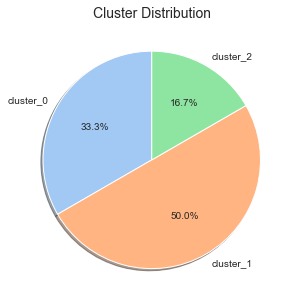

In [13]:
labels = []
sizes = []

for i in range(3):
    labels.append('cluster_'+str(i))
    sizes.append(collections.Counter(t_data)[i])

f, ax = plt.subplots(figsize = (10,5))
plt.pie(sizes,
        labels = labels,
        shadow = True,
        startangle = 90,
        autopct = '%1.1f%%')

plt.title('Cluster Distribution', fontsize = 14)
plt.show()

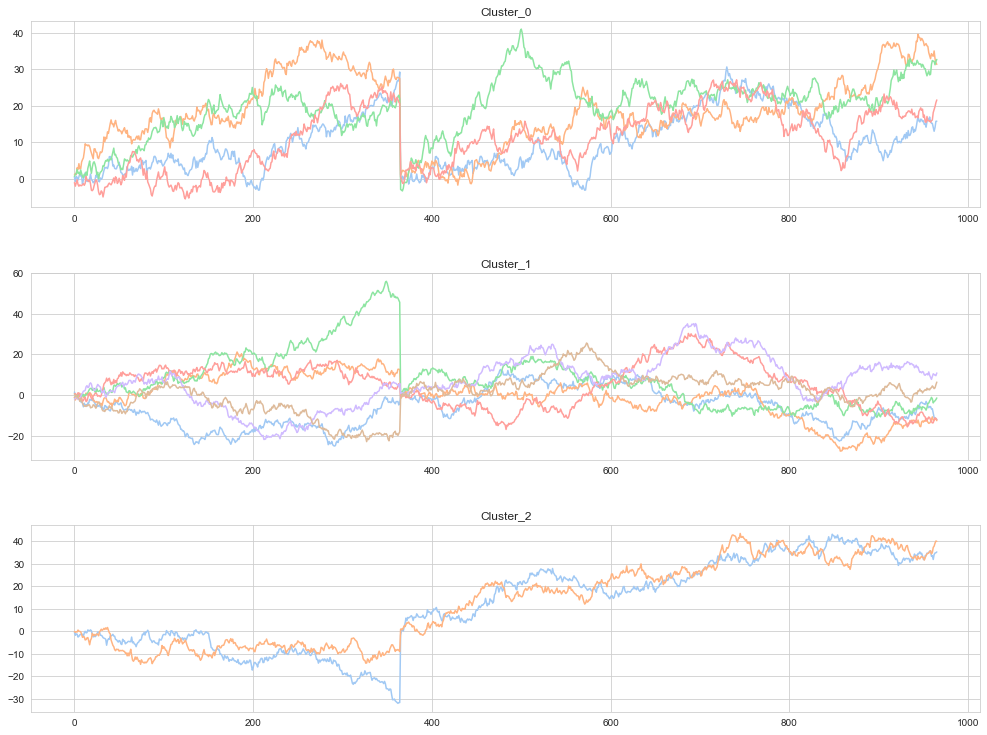

In [14]:
plt.figure(figsize = (17, 12)) 

ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

pd.DataFrame(data[[t_data==0]].reshape(-1,966)).T.plot(ax = ax1, legend = None).set_title('Cluster_0', fontsize = 12)
pd.DataFrame(data[[t_data==1]].reshape(-1,966)).T.plot(ax = ax2, legend = None).set_title('Cluster_1', fontsize = 12)
pd.DataFrame(data[[t_data==2]].reshape(-1,966)).T.plot(ax = ax3, legend = None).set_title('Cluster_2', fontsize = 12)

plt.subplots_adjust(left = 0.125,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.2, 
                    hspace = 0.35)
plt.show()

- Clustering이 잘 되었는지는 모르겠지만 비교적 잘 된거같다.
- Cluster_2는 두 라인이 거의 유사하다고 볼수있고 cluster_0, cluster_1역시 여러개가 겹쳐져있어서 보기 힘들지만 비슷한 성격을 가진 그래프들이 묶여있는듯하다.